In [1]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sb
import pickle as pkl
from braindecode.datasets import BaseConcatDataset, create_from_X_y
from shutil import copyfile
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from data_util import load_subjects, load_subject_data, load_data, euclidean_alignment, label_alignment
from alignment import np_compute_transform_mat, np_euclidean_alignment, np_compute_target_transform_mats, np_label_alignment
from util import np_standardize

In [2]:
# data_dir = "/content/drive/MyDrive/DataVIN/Official"
# als_data_dir = "/content/drive/MyDrive/VIN_ALS"
data_dir = "../data/vin/Official"
als_data_dir = "../data/vin/Official"

In [3]:
%%time
# fmt: off
# subjects = [
#     'K300', 'K309', 'K310', 'K311', 'K312', 
#     'K313', 'K314', 'K315', 'K316', 'K319', 
#     'K320', 'K321', 'K322', 'K323', 'K324', 
#     'K325', 'K326', 'K327', 'K328', 'K329', 
#     'K330', 'K331', 'K332', 'K333', 'K334', 
#     'K335', 'K336', 'K337', 'K338', 'K339', 
#     'K340', 'K342', 'K343', 'K344', 'K350', 
#     'K351', 'K352', 'K353', 'K354', 'K355', 
#     'K356', 'K357', 'K358', 'K359', 'K360', 
#     'K361', 'K362', 'K363', 'K364', 'K365', 
#     'K366', 'K367', 'K368', 'K369', 'K370', 
#     'K371', 'K372', 'K373', 'K374', 'K375',
# ]

subjects = [
    'K001', 'K002', 'K003', 'K004',
    'K005', 'K006', 'K007', 'K008', 'K009',
    'K010', 'K011', 'K012', 'K013', 'K014',
    'K015', 'K016', 'K017', 'K018', 'K019',
    'K020', 'K021', 'K022', 'K023', 'K024',
    'K025', 'K026', 'K027', 'K028', 'K299',
    'K300', 'K301', 'K302', 'K303', 'K304',
    'K305', 'K306', 'K307', 'K308', 'K309',
    'K310', 'K311', 'K312', 'K313', 'K314',
    'K315', 'K316', 'K317', 'K319',
    'K320', 'K321', 'K322', 'K323', 'K324',
    'K325', 'K326', 'K327', 'K328', 'K329',
    'K330', 'K331', 'K332', 'K333', 'K334',
    'K335', 'K336', 'K337', 'K338', 'K339',
    'K340', 'K342', 'K343', 'K344', 'K350',
    'K351', 'K352', 'K353', 'K354', 'K355',
    'K356', 'K357', 'K358', 'K359', 'K360',
    'K361', 'K362', 'K363', 'K364', 'K365',
    'K366', 'K367', 'K368', 'K369', 'K370',
    'K371', 'K372', 'K373', 'K374', 'K375',
]

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    # "gật đầu",
    # "lắc đầu",
    # "há miệng",
]

events = [
    "Thinking",
    # "Thinking and Acting",
    "Resting",
    # "Typing",
]

channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    # "FC5", "FC1", "FC2", "FC6",
    "T7", "C3", "Cz", "C4", "T8",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    "PO9", "O1", "Oz", "O2", "PO10",
    # "O1", "Oz", "O2",
]
# channels = [
#     # "F3", "Fz", "F4",
#     "FC5", "FC1", "FC2", "FC6",
#     "C3", "Cz", "C4",
#     "CP5", "CP1", "CP2", "CP6",
#     # "P3", "Pz", "P4",
# ]

label_mapping={
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
    # "nâng tay trái_Thinking": "nâng tay",
    # "nâng tay phải_Thinking": "nâng tay",
    # "nâng tay trái_Thinking": "mi",
    # "nâng tay phải_Thinking": "mi",
    "nâng chân trái_Thinking": "nâng chân trái",
    "nâng chân phải_Thinking": "nâng chân phải",
    # "nâng chân trái_Thinking": "nâng chân",
    # "nâng chân phải_Thinking": "nâng chân",
    # "nâng chân trái_Thinking": "mi",
    # "nâng chân phải_Thinking": "mi",
    "gật đầu_Thinking": "gật đầu",
    "lắc đầu_Thinking": "lắc đầu",
    # "gật đầu_Thinking": "đầu",
    # "lắc đầu_Thinking": "đầu",
    # "gật đầu_Thinking": "mi",
    # "lắc đầu_Thinking": "mi",
    "há miệng_Thinking": "há miệng",
    # "há miệng_Thinking": "mi",
    # "nâng tay trái_Thinking and Acting": "nâng tay trái",
    # "nâng tay phải_Thinking and Acting": "nâng tay phải",
    # "nâng chân trái_Thinking and Acting": "nâng chân trái",
    # "nâng chân phải_Thinking and Acting": "nâng chân phải",
    # "gật đầu_Thinking and Acting": "gật đầu",
    # "lắc đầu_Thinking and Acting": "lắc đầu",
    # "há miệng_Thinking and Acting": "há miệng",
    "Resting": "rest",
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 3  # @param
window_duration = 2  # @param
window_stride_duration = 0.5  # @param

fmin = 8.0  # @param
fmax = 30.0  # @param

ds = load_data(
    data_dir,  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=False,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

# als_subjects = ["ALS01_t1", "ALS01_t2", "ALS02_t1", "ALS02_t2"]

# als_ds = load_data(
#     als_data_dir,  
#     subjects=als_subjects,
#     scenarios=scenarios,
#     events=events,
#     channels=channels,
#     label_mapping=label_mapping,
#     minimal_trial_duration=minimal_trial_duration,
#     window_duration=window_duration, 
#     window_stride_duration=window_stride_duration, 
#     start_offset=0,
#     stop_offset=0,
#     fmin=fmin, 
#     fmax=fmax, 
#     moving_standardize=False,
#     resample=None,
#     return_raw=False,
#     return_preprocessed=False,
#     preload=True,
# )

# ds = BaseConcatDataset([ds, als_ds])

# fmt: on

# for _ds in ds.datasets:
#     _ds_info = _ds.description
#     if _ds_info["subject"] == "K314":
#         _ds_info["subject"] = "K314_t1"
#     elif _ds_info["subject"] == "K324":
#         _ds_info["subject"] = "K314_t2"

ds_info = ds.description

ds_info["epochs"] = 0
for i, r in ds_info.iterrows():
    ds_info.loc[i, "epochs"] = len(ds.datasets[i].windows)

print(f"loaded {len(ds_info['subject'].unique())} subjects - {ds_info['epochs'].sum()} epochs")
ds_info

using 32 channels


subject:  16%|█████▏                           | 17/109 [00:00<00:01, 47.60it/s]/home/txdat/code/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/txdat/code/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  25%|████████▏                        | 27/109 [00:00<00:01, 41.95it/s]/home/txdat/code/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  29%|█████████▋                       | 32/109 [00:00<00:01, 43.39it/s]/home/txdat/code/eeg-motor-imagery/notebooks/data_util.py:211: Runtime

loaded 96 subjects - 24621 epochs
CPU times: user 36.9 s, sys: 2.13 s, total: 39.1 s
Wall time: 42.2 s


,subject,scenario,event,label,trial,split,epochs
0,K001,nâng tay trái,Thinking,nâng tay trái,0,train,9
1,K001,nâng tay trái,Resting,rest,0,train,10
2,K001,nâng tay trái,Resting,rest,1,train,5
3,K001,nâng tay trái,Thinking,nâng tay trái,1,train,10
4,K001,nâng tay trái,Resting,rest,2,train,4
...,...,...,...,...,...,...,...
2713,K375,nâng chân phải,Resting,rest,2,train,4
2714,K375,nâng chân phải,Resting,rest,3,train,5
2715,K375,nâng chân phải,Thinking,nâng chân phải,2,train,11
2716,K375,nâng chân phải,Resting,rest,4,train,6


In [5]:
from pyriemann.utils.distance import distance_riemann
from pyriemann.utils.mean import mean_riemann

In [6]:
subjects = sorted(ds_info["subject"].unique())

dist = np.zeros((len(subjects), len(subjects)), dtype=np.float32)

subject_mean = dict()
for sub in tqdm(subjects, total=len(subjects), desc="subject"):
    if sub == "K318":
        continue
    
    X = list()
    for i, r in ds_info[(ds_info["subject"] == sub) & (ds_info["label"] == "nâng tay trái")].iterrows():
        X.append(ds.datasets[i].windows.get_data())

    X = np.concatenate(X, axis=0)
    C = np.stack([np.cov(x, rowvar=True) for x in X])
    subject_mean[sub] = mean_riemann(C)

for i1, sub1 in tqdm(enumerate(subjects), total=len(subjects), desc="subject"):
    if sub1 == "K318":
        continue
    
    for i2, sub2 in enumerate(subjects):
        if i1 == i2:
            continue
        if sub2 == "K318":
            continue
            
        dist[i1, i2] = distance_riemann(subject_mean[sub1], subject_mean[sub2])
        dist[i2, i1] = dist[i1, i2]

subject: 100%|██████████████████████████████████| 96/96 [00:01<00:00, 64.78it/s]


<AxesSubplot:>

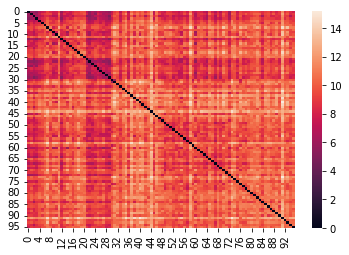

In [7]:
sb.heatmap(dist)

In [8]:
indices = np.argsort(dist, axis=1)

In [9]:
subject_map = {sub: i for i, sub in enumerate(subjects)}

In [10]:
[subjects[i] for i in indices[subject_map["K300"]][:20]]

['K300',
 'K024',
 'K023',
 'K001',
 'K301',
 'K003',
 'K025',
 'K299',
 'K028',
 'K013',
 'K004',
 'K334',
 'K002',
 'K005',
 'K342',
 'K328',
 'K352',
 'K305',
 'K027',
 'K026']

In [11]:
dist[subject_map["K300"], subject_map["K024"]]

5.823506

/home/txdat/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

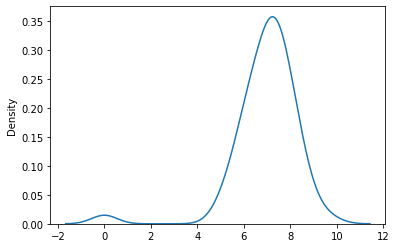

In [37]:
sb.distplot(dist[subject_map["K300"]], hist=False)